# CVAE - Conditional VAE

In [49]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import pickle
from sklearn.model_selection import StratifiedKFold


In [50]:

# ======================
# CONFIG
# ======================
DATA_PATH = "dataset_THCS_only_filtered.csv"
OUT_DIR = Path("cvae_discrete_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

TARGET = "p1q9_job_current"
N_CLASSES = 6

SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Train CVAE
EPOCHS = 250
BATCH_SIZE = 128
LR = 1e-3
LATENT = 32
HIDDEN = 256

BETA = 1.0
WARMUP_EPOCHS = 50
EARLY_STOP_PATIENCE = 25

# Hold-out
TEST_SIZE = 0.2

# Synthetic target:
# Default: bring class 4&5 up to min(count of classes 0..3) within TRAIN
SYN_CLASSES = [4, 5]

# IMPORTANT SAFETY CAPS (highly recommended for your data)
# - cap_factor: don't generate more than cap_factor * real_count for a class
# - min_real_to_generate: if class has < this many real samples, generation is extremely risky
CAP_FACTOR = 40           # e.g. at most 4x the real count
MIN_REAL_TO_GENERATE = 8  # class < 8 => warn (still generate if you insist)
FORCE_GENERATE_ANYWAY = True  # set False to skip too-small classes automatically


# ======================
# Reproducibility
# ======================
def set_seed(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# ======================
# Column grouping (purely value-based)
# - Any negative values -> categorical
# - Binary {0,1}
# - Likert subset of {1..5}
# - Small integer code (<=20 unique) -> categorical
# ======================
@dataclass
class ColumnGroups:
    binary: List[str]
    likert: List[str]
    categorical: List[str]
    other_numeric: List[str]


def infer_column_groups(df: pd.DataFrame, feature_cols: List[str]) -> ColumnGroups:
    binary, likert, categorical, other_numeric = [], [], [], []

    for c in feature_cols:
        s = df[c].dropna()
        if len(s) == 0:
            categorical.append(c)
            continue

        if (s < 0).any():
            categorical.append(c)
            continue

        uniq = np.sort(s.unique())

        if len(uniq) <= 2 and set(uniq).issubset({0, 1}):
            binary.append(c)
            continue

        if set(uniq).issubset({1, 2, 3, 4, 5}):
            likert.append(c)
            continue

        # small integer code -> categorical
        is_int_like = pd.api.types.is_integer_dtype(s) or np.all(np.equal(np.mod(uniq, 1), 0))
        if is_int_like and len(uniq) <= 20:
            categorical.append(c)
            continue

        other_numeric.append(c)

    return ColumnGroups(binary=binary, likert=likert, categorical=categorical, other_numeric=other_numeric)


# ======================
# Categorical encoder (per-column index mapping)
# ======================
@dataclass
class CatEncoder:
    cols: List[str]
    categories_: Dict[str, np.ndarray]
    to_index_: Dict[str, Dict[float, int]]
    to_value_: Dict[str, Dict[int, float]]

    @staticmethod
    def fit(df: pd.DataFrame, cols: List[str]) -> "CatEncoder":
        categories_ = {}
        to_index_ = {}
        to_value_ = {}

        for c in cols:
            cats = np.sort(df[c].dropna().unique())
            categories_[c] = cats
            to_index_[c] = {float(v): i for i, v in enumerate(cats)}
            to_value_[c] = {i: float(v) for i, v in enumerate(cats)}

        return CatEncoder(cols, categories_, to_index_, to_value_)

    def transform(self, df: pd.DataFrame) -> np.ndarray:
        out = np.zeros((len(df), len(self.cols)), dtype=np.int64)
        for j, c in enumerate(self.cols):
            m = self.to_index_[c]
            out[:, j] = df[c].map(lambda x: m.get(float(x), 0)).to_numpy(dtype=np.int64)
        return out

    def inverse_transform(self, X_idx: np.ndarray) -> pd.DataFrame:
        data = {}
        for j, c in enumerate(self.cols):
            inv = self.to_value_[c]
            data[c] = np.vectorize(lambda i: inv.get(int(i), inv[0]))(X_idx[:, j])
        return pd.DataFrame(data)


# ======================
# PreparedData
# ======================
@dataclass
class PreparedData:
    groups: ColumnGroups
    cat_enc: CatEncoder
    binary_cols: List[str]
    likert_cols: List[str]
    cat_cols: List[str]
    cat_sizes: List[int]


def prepare(df_train: pd.DataFrame, feature_cols: List[str]) -> PreparedData:
    groups = infer_column_groups(df_train, feature_cols)
    cat_enc = CatEncoder.fit(df_train, groups.categorical)
    cat_sizes = [len(cat_enc.categories_[c]) for c in groups.categorical]

    return PreparedData(
        groups=groups,
        cat_enc=cat_enc,
        binary_cols=groups.binary,
        likert_cols=groups.likert,
        cat_cols=groups.categorical,
        cat_sizes=cat_sizes
    )


def to_model_inputs(df: pd.DataFrame, prep: PreparedData) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # binary float32 0/1
    Xb = df[prep.binary_cols].to_numpy(dtype=np.float32) if prep.binary_cols else np.zeros((len(df), 0), np.float32)

    # likert indices 0..4
    if prep.likert_cols:
        Xl = df[prep.likert_cols].to_numpy(dtype=np.int64) - 1
        Xl = np.clip(Xl, 0, 4)
    else:
        Xl = np.zeros((len(df), 0), dtype=np.int64)

    # categorical indices per col 0..K-1
    Xc = prep.cat_enc.transform(df) if prep.cat_cols else np.zeros((len(df), 0), dtype=np.int64)

    return Xb, Xl, Xc


def onehot_y(y: np.ndarray, n_classes: int) -> np.ndarray:
    oh = np.zeros((len(y), n_classes), dtype=np.float32)
    oh[np.arange(len(y)), y.astype(int)] = 1.0
    return oh


# ======================
# CVAE Mixed-type (Discrete)
# Condition y via concatenation in BOTH encoder and decoder
# Encoder input = [x_onehot_expanded, y_onehot]
# Decoder input = [z, y_onehot]
# ======================
class CVAE_Discrete(nn.Module):
    def __init__(self, n_bin: int, n_likert: int, cat_sizes: List[int], y_dim: int):
        super().__init__()
        self.n_bin = n_bin
        self.n_likert = n_likert
        self.cat_sizes = cat_sizes
        self.y_dim = y_dim

        # expanded x for encoder:
        # binary float n_bin
        # likert one-hot 5 each => n_likert*5
        # categorical one-hot sum(cat_sizes)
        x_enc_dim = n_bin + n_likert * 5 + int(np.sum(cat_sizes))
        enc_in = x_enc_dim + y_dim

        self.enc = nn.Sequential(
            nn.Linear(enc_in, HIDDEN),
            nn.ReLU(),
            nn.Linear(HIDDEN, HIDDEN),
            nn.ReLU()
        )
        self.mu = nn.Linear(HIDDEN, LATENT)
        self.logvar = nn.Linear(HIDDEN, LATENT)

        self.dec_trunk = nn.Sequential(
            nn.Linear(LATENT + y_dim, HIDDEN),
            nn.ReLU(),
            nn.Linear(HIDDEN, HIDDEN),
            nn.ReLU()
        )

        # heads
        self.bin_head = nn.Linear(HIDDEN, n_bin) if n_bin > 0 else None
        self.likert_head = nn.Linear(HIDDEN, n_likert * 5) if n_likert > 0 else None
        self.cat_heads = nn.ModuleList([nn.Linear(HIDDEN, k) for k in cat_sizes])

    def _encode_x(self, xb: torch.Tensor, xl: torch.Tensor, xc: torch.Tensor) -> torch.Tensor:
        parts = []
        if self.n_bin > 0:
            parts.append(xb)

        if self.n_likert > 0:
            xl_oh = F.one_hot(xl, num_classes=5).float()  # [B, n_likert, 5]
            parts.append(xl_oh.view(xl_oh.size(0), -1))

        if len(self.cat_sizes) > 0:
            oh_list = []
            for j, k in enumerate(self.cat_sizes):
                oh_list.append(F.one_hot(xc[:, j], num_classes=k).float())
            parts.append(torch.cat(oh_list, dim=1))

        return torch.cat(parts, dim=1) if parts else torch.zeros((xb.size(0), 0), device=xb.device)

    def forward(self, xb: torch.Tensor, xl: torch.Tensor, xc: torch.Tensor, y_oh: torch.Tensor):
        x_in = self._encode_x(xb, xl, xc)
        h = self.enc(torch.cat([x_in, y_oh], dim=1))
        mu = self.mu(h)
        logvar = self.logvar(h)

        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)

        hd = self.dec_trunk(torch.cat([z, y_oh], dim=1))

        bin_logits = self.bin_head(hd) if self.bin_head is not None else None
        likert_logits = self.likert_head(hd).view(-1, self.n_likert, 5) if self.likert_head is not None else None
        cat_logits = [head(hd) for head in self.cat_heads]  # list [B,k]

        return bin_logits, likert_logits, cat_logits, mu, logvar

    @torch.no_grad()
    def sample(self, n: int, class_id: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        z = torch.randn((n, LATENT), device=DEVICE)
        y = torch.zeros((n, self.y_dim), device=DEVICE)
        y[:, class_id] = 1.0

        hd = self.dec_trunk(torch.cat([z, y], dim=1))

        # binary
        if self.bin_head is not None:
            p = torch.sigmoid(self.bin_head(hd))
            xb = torch.bernoulli(p).cpu().numpy().astype(np.int64)
        else:
            xb = np.zeros((n, 0), dtype=np.int64)

        # likert
        if self.likert_head is not None:
            logits = self.likert_head(hd).view(n, self.n_likert, 5)
            probs = torch.softmax(logits, dim=-1)
            xl = torch.multinomial(probs.view(-1, 5), 1).view(n, self.n_likert).cpu().numpy().astype(np.int64)
        else:
            xl = np.zeros((n, 0), dtype=np.int64)

        # categorical
        xc_list = []
        for head in self.cat_heads:
            probs = torch.softmax(head(hd), dim=-1)
            idx = torch.multinomial(probs, 1).squeeze(1)
            xc_list.append(idx.cpu().numpy().astype(np.int64))
        xc = np.stack(xc_list, axis=1) if xc_list else np.zeros((n, 0), dtype=np.int64)

        return xb, xl, xc

def cvae_loss_improved(
    bin_logits, likert_logits, cat_logits,
    xb, xl, xc,
    mu, logvar,
    beta: float,
    n_bin: int,
    n_likert: int,
    n_cat: int,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:  # ✅ Trả về tuple
    """
    Reconstruction loss normalized by number of features per type
    Returns: (total_loss, recon_loss, kl_loss)
    """

    recon = 0.0
    total_feats = 0

    # Binary
    if bin_logits is not None and xb.numel() > 0 and n_bin > 0:
        recon_bin = F.binary_cross_entropy_with_logits(
            bin_logits, xb, reduction="mean"
        )
        recon = recon + recon_bin * n_bin
        total_feats += n_bin

    # Likert
    if likert_logits is not None and xl.numel() > 0 and n_likert > 0:
        recon_lik = F.cross_entropy(
            likert_logits.view(-1, 5),
            xl.view(-1),
            reduction="mean"
        )
        recon = recon + recon_lik * n_likert
        total_feats += n_likert

    # Categorical
    if cat_logits and xc.numel() > 0 and n_cat > 0:
        ce_list = []
        for j, logits in enumerate(cat_logits):
            ce_list.append(
                F.cross_entropy(logits, xc[:, j], reduction="mean")
            )
        recon_cat = torch.stack(ce_list).mean()
        recon = recon + recon_cat * n_cat
        total_feats += n_cat

    # Normalize
    if total_feats > 0:
        recon = recon / total_feats

    # KL divergence
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    total_loss = recon + beta * kl
    return total_loss, recon, kl  # ✅


def train_cvae(
    Xb: np.ndarray, Xl: np.ndarray, Xc: np.ndarray, y: np.ndarray,
    prep: PreparedData
) -> CVAE_Discrete:
    
    idx = np.arange(len(y))
    idx_tr, idx_va = train_test_split(idx, test_size=0.15, random_state=SEED, stratify=y)

    def make_loader(ix, shuffle: bool):
        xb = torch.tensor(Xb[ix], dtype=torch.float32)
        xl = torch.tensor(Xl[ix], dtype=torch.long)
        xc = torch.tensor(Xc[ix], dtype=torch.long)
        y_oh = torch.tensor(onehot_y(y[ix], N_CLASSES), dtype=torch.float32)
        ds = TensorDataset(xb, xl, xc, y_oh)
        return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle, drop_last=False)

    dl_tr = make_loader(idx_tr, True)
    dl_va = make_loader(idx_va, False)

    model = CVAE_Discrete(
        n_bin=Xb.shape[1],
        n_likert=Xl.shape[1],
        cat_sizes=prep.cat_sizes,
        y_dim=N_CLASSES
    ).to(DEVICE)

    opt = torch.optim.Adam(model.parameters(), lr=LR)

    best_val = float("inf")
    patience = 0
    best_state = None

    for epoch in range(1, EPOCHS + 1):
        beta = BETA * min(1.0, epoch / float(WARMUP_EPOCHS))

        # ========== TRAINING ==========
        model.train()
        for xb, xl, xc, y_oh in dl_tr:
            xb, xl, xc, y_oh = xb.to(DEVICE), xl.to(DEVICE), xc.to(DEVICE), y_oh.to(DEVICE)

            bin_logits, likert_logits, cat_logits, mu, logvar = model(xb, xl, xc, y_oh)
            
            loss, _, _ = cvae_loss_improved(  # ✅ Unpack tuple
                bin_logits, likert_logits, cat_logits,
                xb, xl, xc,
                mu, logvar,
                beta=beta,
                n_bin=len(prep.binary_cols),
                n_likert=len(prep.likert_cols),
                n_cat=len(prep.cat_cols),
            )

            opt.zero_grad()
            loss.backward()
            opt.step()

        # ========== VALIDATION ==========
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, xl, xc, y_oh in dl_va:
                xb, xl, xc, y_oh = xb.to(DEVICE), xl.to(DEVICE), xc.to(DEVICE), y_oh.to(DEVICE)
                bin_logits, likert_logits, cat_logits, mu, logvar = model(xb, xl, xc, y_oh)
                
                val_loss, _, _ = cvae_loss_improved(  # ✅ Unpack tuple
                    bin_logits, likert_logits, cat_logits,
                    xb, xl, xc,
                    mu, logvar,
                    beta=beta,
                    n_bin=len(prep.binary_cols),
                    n_likert=len(prep.likert_cols),
                    n_cat=len(prep.cat_cols),
                )
                val_losses.append(val_loss.item())  # ✅ THÊM .item()

        val_loss = float(np.mean(val_losses))

        # Early stopping
        if val_loss + 1e-6 < best_val:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience = 0
        else:
            patience += 1
            if patience >= EARLY_STOP_PATIENCE:
                print(f"Early stopping at epoch {epoch}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    return model


# ======================
# Export helpers for bar comparison
# ======================
def make_bar_df_from_samples(
    prep: PreparedData,
    xb_s: np.ndarray, xl_s: np.ndarray, xc_s: np.ndarray,
    cls: int
) -> pd.DataFrame:
    data = {}

    # binary
    for j, c in enumerate(prep.binary_cols):
        data[c] = xb_s[:, j].astype(int)

    # likert back to 1..5
    for j, c in enumerate(prep.likert_cols):
        data[c] = (xl_s[:, j] + 1).astype(int)

    # categorical back to original codes
    if prep.cat_cols:
        df_cat = prep.cat_enc.inverse_transform(xc_s)
        for c in prep.cat_cols:
            data[c] = df_cat[c].values

    df_out = pd.DataFrame(data)
    df_out[TARGET] = cls
    df_out["source"] = "synthetic"
    return df_out


def main():
    set_seed(SEED)

    df = pd.read_csv(DATA_PATH)
    if TARGET not in df.columns:
        raise ValueError(f"Missing target '{TARGET}' in {DATA_PATH}")

    feature_cols = [c for c in df.columns if c != TARGET]

    # Hold-out split (stratified)
    df_tr, df_te = train_test_split(df, test_size=TEST_SIZE, random_state=SEED, stratify=df[TARGET])
    df_tr = df_tr.reset_index(drop=True)
    df_te = df_te.reset_index(drop=True)

    # Fit preprocessing on TRAIN only
    prep = prepare(df_tr, feature_cols)

    # Prepare model inputs on TRAIN (all classes)
    Xb_tr, Xl_tr, Xc_tr = to_model_inputs(df_tr, prep)
    y_tr = df_tr[TARGET].astype(int).to_numpy()

    # Train 1 CVAE on TRAIN
    cvae = train_cvae(Xb_tr, Xl_tr, Xc_tr, y_tr, prep)
    torch.save(cvae.state_dict(), OUT_DIR / "cvae_discrete.pt")

    # Compute target count (min among 0..3)
    counts = df_tr[TARGET].value_counts().to_dict()
    target_n = min(counts.get(k, 0) for k in [0, 1, 2, 3])

    plan_rows = []
    synthetic_frames = []

    # Save REAL train subset for bar comparison
    keep_cols = prep.binary_cols + prep.likert_cols + prep.cat_cols
    df_real_bar = df_tr[keep_cols].copy()
    df_real_bar[TARGET] = df_tr[TARGET].astype(int)
    df_real_bar["source"] = "real"
    df_real_bar.to_csv(OUT_DIR / "real_train_for_bar.csv", index=False)

    for cls in SYN_CLASSES:
        cur = int(counts.get(cls, 0))
        need = max(0, target_n - cur)

        # caps to avoid extreme oversampling (strongly recommended)
        cap = int(max(0, CAP_FACTOR * cur))
        if cap > 0:
            need_capped = min(need, cap)
        else:
            need_capped = need

        too_small = cur < MIN_REAL_TO_GENERATE
        if too_small and not FORCE_GENERATE_ANYWAY:
            need_capped = 0

        plan_rows.append({
            "class": cls,
            "current_train_count": cur,
            "target_train_count": int(target_n),
            "need_raw": int(need),
            "need_capped": int(need_capped),
            "cap_factor": CAP_FACTOR,
            "min_real_to_generate": MIN_REAL_TO_GENERATE,
            "forced_generate_anyway": FORCE_GENERATE_ANYWAY,
            "warning_too_few_real": bool(too_small),
        })

        if need_capped <= 0:
            continue

        # Sample synthetic with condition class_id
        xb_s, xl_s, xc_s = cvae.sample(n=need_capped, class_id=cls)

        df_syn_bar = make_bar_df_from_samples(prep, xb_s, xl_s, xc_s, cls)
        synthetic_frames.append(df_syn_bar)

    pd.DataFrame(plan_rows).to_csv(OUT_DIR / "synth_plan.csv", index=False)

    if synthetic_frames:
        df_syn_all = pd.concat(synthetic_frames, ignore_index=True)
        df_syn_all.to_csv(OUT_DIR / "synthetic_for_bar.csv", index=False)
        df_bar = pd.concat([df_real_bar, df_syn_all], ignore_index=True)
    else:
        df_bar = df_real_bar.copy()

    df_bar.to_csv(OUT_DIR / "real_vs_synthetic_for_bar.csv", index=False)

    print("\nSaved outputs to:", OUT_DIR.resolve())
    print("Train class counts:\n", df_tr[TARGET].value_counts().sort_index())
    print("Test  class counts:\n", df_te[TARGET].value_counts().sort_index())
    print("\nSynthesis plan:\n", pd.DataFrame(plan_rows))
    print("\nFiles:")
    print(" -", (OUT_DIR / "cvae_discrete.pt").resolve())
    print(" -", (OUT_DIR / "synth_plan.csv").resolve())
    print(" -", (OUT_DIR / "real_vs_synthetic_for_bar.csv").resolve())


if __name__ == "__main__":
    main()


Early stopping at epoch 44

Saved outputs to: C:\Users\Admin\Desktop\TANPHAT\hocotruong\Năm ba 2025-2026\HK1_B\Thống kê máy tính và ứng dụng\PT_Phieu\cvae_discrete_outputs
Train class counts:
 p1q9_job_current
0    318
1    113
2     74
3     89
4     11
5      2
Name: count, dtype: int64
Test  class counts:
 p1q9_job_current
0    80
1    28
2    18
3    22
4     3
5     1
Name: count, dtype: int64

Synthesis plan:
    class  current_train_count  target_train_count  need_raw  need_capped  \
0      4                   11                  74        63           63   
1      5                    2                  74        72           72   

   cap_factor  min_real_to_generate  forced_generate_anyway  \
0          40                     8                    True   
1          40                     8                    True   

   warning_too_few_real  
0                 False  
1                  True  

Files:
 - C:\Users\Admin\Desktop\TANPHAT\hocotruong\Năm ba 2025-2026\HK1_B\Thống k

# Trực quan kết quả

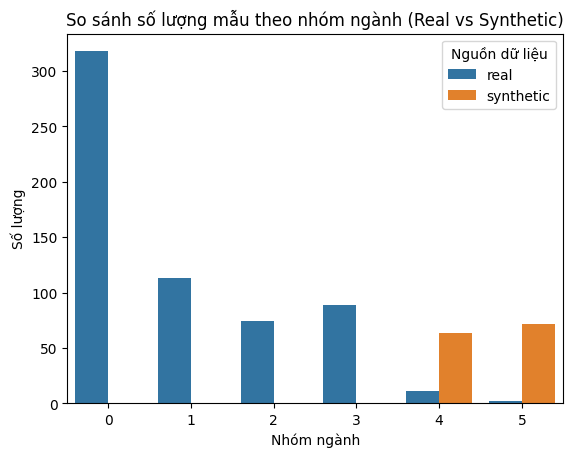

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(r"cvae_discrete_outputs\real_vs_synthetic_for_bar.csv")

sns.countplot(
    data=df,
    x="p1q9_job_current",
    hue="source"
)

plt.title("So sánh số lượng mẫu theo nhóm ngành (Real vs Synthetic)")
plt.xlabel("Nhóm ngành")
plt.ylabel("Số lượng")
plt.legend(title="Nguồn dữ liệu")
plt.show()

# 🔄 Chiến Lược Kiểm Định: Stratified K-Fold Cross-Validation

In [52]:
# ======================
# CONFIG
# ======================
DATA_PATH = r"cvae_discrete_outputs\synthetic_for_bar.csv"
OUT_DIR = Path("cvae_cv_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

TARGET = "p1q9_job_current"
N_SPLITS = 3
SEED = 42

# ======================
# LOAD DATA
# ======================
df1 = pd.read_csv(DATA_PATH)
df1.drop(columns=['source'], inplace=True)

In [53]:
df2 = pd.read_csv(r"dataset_THCS_only_filtered.csv")

df = pd.concat(
    [df1, df2],
    ignore_index=True
)


In [54]:

X = df.drop(columns=[TARGET])
y = df[TARGET]

# ======================
# FULL CLASS DISTRIBUTION
# ======================
class_counts_full = (
    y.value_counts()
     .rename_axis("class")
     .reset_index(name="count")
     .sort_values("class")
)
# Lưu lại số lượng từng lớp
class_counts_full.to_csv(
    OUT_DIR / "class_counts_full.csv",
    index=False
)


# ======================
# STRATIFIED K-FOLD (3 folds)
# ======================
skf = StratifiedKFold(
    n_splits=N_SPLITS,
    shuffle=True,
    random_state=SEED
)

fold_indices = []
per_fold_counts = []

for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    fold_indices.append({
        "fold": fold_id,
        "train_idx": train_idx,
        "val_idx": val_idx,
    })

    # class distribution in validation fold
    fold_counts = (
        y.iloc[val_idx]
        .value_counts()
        .rename_axis("class")
        .reset_index(name="count")
    )
    fold_counts["fold"] = fold_id
    per_fold_counts.append(fold_counts)

# ======================
# SAVE FOLDS
# ======================
with open(OUT_DIR / "cvae_cv_folds.pkl", "wb") as f:
    pickle.dump(fold_indices, f)

class_counts_per_fold = (
    pd.concat(per_fold_counts, ignore_index=True)
      .sort_values(["fold", "class"])
)

class_counts_per_fold.to_csv(
    OUT_DIR / "class_counts_per_fold.csv",
    index=False
)

print("DONE")
print(f"- Total samples: {len(df)}")
print(f"- Folds: {N_SPLITS}")
print("- Full class distribution:")
print(class_counts_full)


DONE
- Total samples: 894
- Folds: 3
- Full class distribution:
   class  count
0      0    398
1      1    141
3      2     92
2      3    111
4      4     77
5      5     75


# Training voi RF

In [55]:
import pickle
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# DATA_PATH = "cvae_discrete_outputs/real_vs_synthetic_for_bar.csv"
FOLDS_PATH = "cvae_cv_outputs/cvae_cv_folds.pkl"
# TARGET = "p1q9_job_current"

# Load data
# df = pd.read_csv(DATA_PATH)
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# Load CV folds (đã chuẩn bị sẵn)
with open(FOLDS_PATH, "rb") as f:
    folds = pickle.load(f)

print("Data shape:", X.shape)
print("Class distribution:\n", y.value_counts().sort_index())


Data shape: (894, 183)
Class distribution:
 p1q9_job_current
0    398
1    141
2     92
3    111
4     77
5     75
Name: count, dtype: int64


In [56]:
rf_base_params = dict(
    n_estimators=800,
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=6,
    max_features="sqrt",
    class_weight="balanced_subsample",
    bootstrap=True,
    n_jobs=-1,
    random_state=42,
)

def run_cv_rf(rf_params, tag=""):
    fold_results = []

    for fold in folds:
        tr_idx = fold["train_idx"]
        va_idx = fold["val_idx"]

        X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
        X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

        model = RandomForestClassifier(**rf_params)
        model.fit(X_tr, y_tr)

        pred = model.predict(X_va)

        bal_acc = balanced_accuracy_score(y_va, pred)
        f1_mac = f1_score(y_va, pred, average="macro")

        print("\n" + "=" * 80)
        print(f"[{tag}] FOLD {fold['fold']}")
        print(f"balanced_accuracy: {bal_acc:.4f}")
        print(f"f1_macro:         {f1_mac:.4f}")
        print("classification_report:")
        print(classification_report(y_va, pred, digits=4))
        print("confusion_matrix:")
        print(confusion_matrix(y_va, pred))

        fold_results.append((bal_acc, f1_mac))

    print("\n" + "#" * 80)
    print(f"[{tag}] MEAN RESULTS")
    print("balanced_accuracy =", np.mean([r[0] for r in fold_results]))
    print("f1_macro          =", np.mean([r[1] for r in fold_results]))


# === RUN BASELINE ===
run_cv_rf(rf_base_params, tag="RF_CVAE")





[RF_CVAE] FOLD 0
balanced_accuracy: 0.3892
f1_macro:         0.3662
classification_report:
              precision    recall  f1-score   support

           0     0.7606    0.8120    0.7855       133
           1     0.4444    0.7660    0.5625        47
           2     0.4231    0.3667    0.3929        30
           3     0.2439    0.2703    0.2564        37
           4     0.0000    0.0000    0.0000        26
           5     0.6000    0.1200    0.2000        25

    accuracy                         0.5638       298
   macro avg     0.4120    0.3892    0.3662       298
weighted avg     0.5328    0.5638    0.5274       298

confusion_matrix:
[[108   6   6  13   0   0]
 [  3  36   2   6   0   0]
 [  7   4  11   8   0   0]
 [  2  20   4  10   1   0]
 [ 10  10   2   2   0   2]
 [ 12   5   1   2   2   3]]

[RF_CVAE] FOLD 1
balanced_accuracy: 0.4219
f1_macro:         0.4077
classification_report:
              precision    recall  f1-score   support

           0     0.7447    0.7955    